# <span style="color:blue"> Different stages of Alzheimer by CNN and Tranfer Learining </span>
Please refer to the corresponding [kaggle link](https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images?select=Alzheimer_s+Dataset) for detals of the data set.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow.keras.applications.mobilenet_v2 as mobilenet
tfl = tf.keras.layers

## Load train and test data sets from images
We use [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) from tensorflow.keras.preprocessing to do this task.

In [6]:
BATCH_SIZE = 32
IMG_SIZE = (176, 208)
print("load train data set:")
train_ds = image_dataset_from_directory("Alzheimer_Dataset/train",
                                        shuffle=True,
                                        batch_size=BATCH_SIZE,
                                        image_size=IMG_SIZE,
                                        color_mode="grayscale",
                                        seed=0)
print("load test data set:")
test_ds = image_dataset_from_directory("Alzheimer_Dataset/test",
                                        shuffle=True,
                                        batch_size=BATCH_SIZE,
                                        image_size=IMG_SIZE,
                                        color_mode="grayscale",
                                        seed=0)

load train data set:
Found 5121 files belonging to 4 classes.
load test data set:
Found 1279 files belonging to 4 classes.


class names are ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


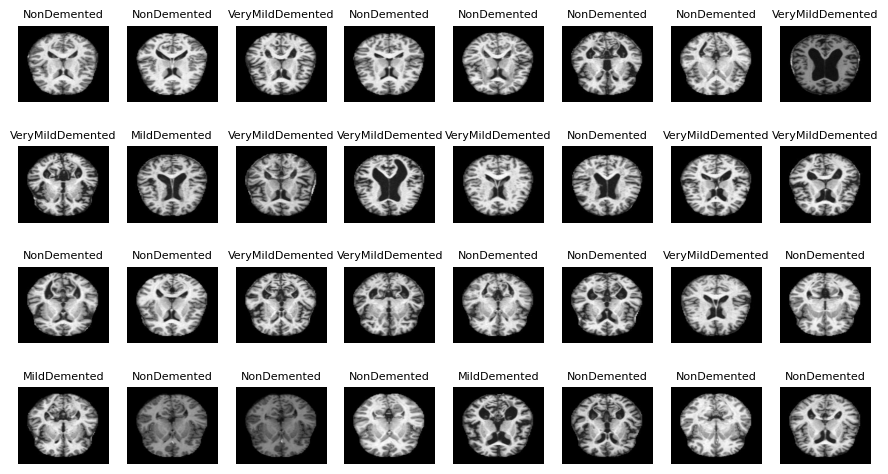

In [8]:
class_names = train_ds.class_names
print(f"class names are {class_names}")
fig, ax = plt.subplots(nrows=4, ncols=8, figsize=(11, 6))
fig.subplots_adjust(wspace=0.2, hspace=0.2)

images, labels = next(iter(train_ds))
for i in range(32):
    a = ax.flat[i]
    a.imshow(images[i].numpy().astype("uint8"), cmap='gray')
    a.set_title(class_names[labels[i]],fontsize = 8)
    a.set_axis_off()

plt.show()

In [10]:
# prefetch the training data
# see the corresponding documentation link at https://www.tensorflow.org/guide/data_performance for detail.
train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Data distribution

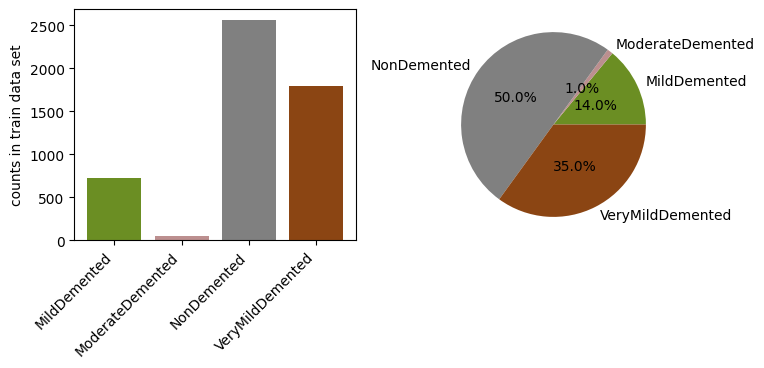

In [9]:
index = np.array([],dtype="int32");
for element in train_ds.as_numpy_iterator():
    index = np.append(index,element[1])
    
unique, counts = np.unique(index, return_counts=True)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
colors=['olivedrab', 'rosybrown', 'gray', 'saddlebrown']
ax[0].bar(unique,counts,color=colors)
ax[0].set_ylabel(f"counts in train data set")
ax[0].set_xticks(np.arange(len(unique)))
ax[0].set_xticklabels([class_names[i] for i in unique], rotation=45, ha='right')

ax[1].pie(counts/counts.sum(), labels=[class_names[i] for i in unique],
          autopct='%1.1f%%',pctdistance=0.5, labeldistance=1.1, colors=colors)


plt.show()

# <span style="color:green"> MACHINE LEARNING </span>

# <span style="color:blue"> CNN by tf.keras.Sequential </span> 

In [120]:
def conv_block(numfilters, padding='same', pool_stride=2):
    model_cb = tf.keras.Sequential([
        tfl.Conv2D(filters=numfilters, kernel_size=3, strides=1, padding=padding, activation='relu'),
        tfl.BatchNormalization(axis=-1),
        tfl.MaxPooling2D(pool_size=2)
    ])
    return model_cb

def dense_block(numunits):
    model_db = tf.keras.Sequential([
        tfl.Dense(numunits, activation='relu'),
        tfl.BatchNormalization(axis=-1),
        tfl.Dropout(rate=0.2)
    ])
    return model_db

IMG_SHAPE = IMG_SIZE + (1,)
model_sequential = tf.keras.Sequential([
    tf.keras.Input(shape=IMG_SHAPE),
    conv_block(16),
    conv_block(32),
    conv_block(64),
    conv_block(128),
    conv_block(256),
    tfl.Flatten(),
    dense_block(128),
    dense_block(64),
    tfl.Dense(units=4, activation='softmax',name='output-layer')
])
model_sequential.summary()

Model: "sequential_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_217 (Sequential)  (None, 88, 104, 16)      224       
                                                                 
 sequential_218 (Sequential)  (None, 44, 52, 32)       4768      
                                                                 
 sequential_219 (Sequential)  (None, 22, 26, 64)       18752     
                                                                 
 sequential_220 (Sequential)  (None, 11, 13, 128)      74368     
                                                                 
 sequential_221 (Sequential)  (None, 5, 6, 256)        296192    
                                                                 
 flatten_29 (Flatten)        (None, 7680)              0         
                                                                 
 sequential_222 (Sequential)  (None, 128)           

In [121]:
model_sequential.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']
)

In [122]:
def scheduler(epoch, lr):
    return lr*(0.1**(0.05*epoch))

my_callbacks = [
    tf.keras.callbacks.LearningRateScheduler(scheduler),
    tf.keras.callbacks.ModelCheckpoint("alzheimer_model_sequential.h5", save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
]

In [123]:
history = model_sequential.fit(train_ds, validation_data=test_ds, callbacks=my_callbacks, epochs=100, batch_size=32, verbose=2)

Epoch 1/100
161/161 - 63s - loss: 1.1941 - accuracy: 0.5276 - val_loss: 0.9550 - val_accuracy: 0.5989 - lr: 0.0010 - 63s/epoch - 392ms/step
Epoch 2/100
161/161 - 62s - loss: 0.6980 - accuracy: 0.7303 - val_loss: 0.9170 - val_accuracy: 0.5981 - lr: 8.9125e-04 - 62s/epoch - 385ms/step
Epoch 3/100
161/161 - 60s - loss: 0.3486 - accuracy: 0.8744 - val_loss: 0.9381 - val_accuracy: 0.6615 - lr: 7.0795e-04 - 60s/epoch - 375ms/step
Epoch 4/100
161/161 - 60s - loss: 0.1266 - accuracy: 0.9606 - val_loss: 1.1022 - val_accuracy: 0.6552 - lr: 5.0119e-04 - 60s/epoch - 375ms/step
Epoch 5/100
161/161 - 61s - loss: 0.0529 - accuracy: 0.9906 - val_loss: 1.1181 - val_accuracy: 0.6912 - lr: 3.1623e-04 - 61s/epoch - 379ms/step
Epoch 6/100
161/161 - 61s - loss: 0.0301 - accuracy: 0.9951 - val_loss: 1.0411 - val_accuracy: 0.6919 - lr: 1.7783e-04 - 61s/epoch - 377ms/step
Epoch 7/100
161/161 - 61s - loss: 0.0208 - accuracy: 0.9977 - val_loss: 0.9132 - val_accuracy: 0.7091 - lr: 8.9125e-05 - 61s/epoch - 377ms/s

**Note:** We could do better probably! But it is good enough for this CNN. We will use Tranfer Learning to get better results.